# Why am I applying for this job?

Always striving for efficiency leaves a person with many opportunities for optimization. I wanted a way to separate jobs seeking a "learning machinist" from a person who is using "machine learning" or the expert in Excel analytics from the billion row data miner. The following python code is an attempt to separate the wheat from the chaff.

### 1.0 Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
plt.rc('font',family='serif')

from pymongo import MongoClient

from bs4 import BeautifulSoup

import os, warnings, pprint, re
from collections import Counter, defaultdict
from datetime import date, timedelta
from itertools import product
from string import punctuation

import numpy as np
import pandas as pd
import seaborn as sns
from pandas import DataFrame, Series, to_datetime

from sklearn.cluster import DBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn import cross_validation, feature_extraction, grid_search, feature_selection
from sklearn import metrics, naive_bayes, pipeline, tree
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from nltk import FreqDist
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams

### 1.1 Housekeeping functions

In [2]:
# pretty print options
pp = pprint.PrettyPrinter(indent=1, width=80)

def top20_by_cluster(i, label):
    """ raw text summary """
    if i == 0:
        print()
        print('Group (Cluster) of primary interest: ' + str(maxCluster4[0]))
        print()
    s = str()
    for d in short_jobDataFrame.desc[short_jobDataFrame[label] == i]:
        s += str(' ' + d).lower()
    print('---------------------------------------')
    print("--- Group number: " + str(i))
    print('---------------------------------------')
    print('--- Top Words by Occurrence')
    print('---------------------------------------')
    word_fd = FreqDist([w for w in word_tokenize(s) if not w in stopwords.words('english') and w not in punctuation])
    for w in word_fd.most_common(9):
        if str(w[0]) != '...': # special case of not punctuation
            pp.pprint(str(w[0]) + ': ' + str(w[1]))
    print('---------------------------------------')
    print('--- Top Bi-Grams:')
    print('---------------------------------------')
    grams_fd = ngrams([w for w in word_tokenize(s) if not w in stopwords.words('english') and w not in punctuation], 2)
    for g in FreqDist([w for w in grams_fd if w[0] != '...' and w[1] != '...']).most_common(10): # see above
        pp.pprint(str(g[0][0]) + ' & ' + str(g[0][1]) + ': ' + str(g[1]))
    print('---------------------------------------')
    print('--- Top Sentences:')
    print('---------------------------------------')
    sent_fd = FreqDist([w for w in sent_tokenize(s)])
    for w in sent_fd.most_common(20):
        if w[1] > 5 and len(w[0]) > 20:
            pp.pprint(w[0] + ': ' + str(w[1]))
    print()
    print()

def label_by_cluster(label, column, count=3):
    """ output job descriptions by column and label """

    for d in short_jobDataFrame.desc[short_jobDataFrame[column] == label][:count]:
        pp.pprint(d)
        print()
        
def dmDistMax(df, title = 'data scientist'):
    """ return most common label with specified job title """

    # subset cluster labels by job title
    c = Counter(df.klab[df.title == title])
    try:
        max_index = c.most_common(1)[0][0]
    except:
        max_index = -1
    return(max_index, c)

In [3]:
# This is included for pedagogical reasons and will differ greatly based on environment 
def setupData():
    """ pull from database and pack into dataframe """
    
    client = MongoClient('localhost', 27020)
    db = client.job
    indeed = db.indeed

    # pull all into lists, to lower, then push to dataframe
    jobCursor = indeed.find()
    element_names = ['jobtitle', 'snippet', 'company', 'date', 'jobkey', 'url']
    dd = defaultdict(list)

    for l in jobCursor[:]:
        # run through the cursor once
        for n in element_names:
            if n == 'date':
                [dd[n].append(j[n]) for j in l['results']]
            elif n == 'snippet':
                [dd[n].append(BeautifulSoup(j[n].lower()).get_text()) for j in l['results']]
            else:
                [dd[n].append(j[n].lower()) for j in l['results']]

    # pack into dataframe
    df = DataFrame({'company': dd['company'],
                'desc': dd['snippet'],
                'url': dd['url'],
                'title': dd['jobtitle'],
                'jobkey': dd['jobkey']},
                index = to_datetime(dd['date']))
    
    # agencies are posting the same jobs with slightly differing descriptions
    # dropped = df.drop_duplicates(subset=['company','desc','title','jobkey'])
    dropped = df.drop_duplicates(subset=['company','jobkey'])
    return(dropped)

### 1.2 Pull in Data

In [4]:
jobDataFrame = setupData()

### 1.3 Feature selection methods for clustering

In [24]:
# Run a randomized search to find a reasonable model
# This is commented out because it takes about 4 hours to run on my computer
#
# add score method to dbscan for (grid/random) search, return 0 for error above
# class Local_DBSCAN(DBSCAN):
#    def score(self, X, y=None):
#        try:
#            s = silhouette_score(X,self.fit(X).labels_)
#        except:
#            s = 0
#            pass
#        return s
#   
# pipe = pipeline.Pipeline([('tfidf', TfidfVectorizer(stop_words = 'english')),
#                          ("ldbscan", Local_DBSCAN())
#                         ])
#
# params = dict(tfidf__use_idf = [True, False],
#               tfidf__smooth_idf = [True, False],
#               tfidf__sublinear_tf = [True, False],
#               tfidf__ngram_range=[(1, 1), (1, 2), (1, 3)],
#               tfidf__norm = ['l1', 'l2'],
#               tfidf__max_features = list(range(2,10)),
#               ldbscan__eps = np.arange(0.1, 0.5, 0.05),
#               ldbscan__min_samples = list(range(10, 26)),
#               ldbscan__leaf_size = list(range(10, 80, 5)),
#              )
#
# random_search = RandomizedSearchCV(pipe,
#                                   param_distributions = params, 
#                                   n_iter = 10000, 
#                                   n_jobs = 4,
#                                   pre_dispatch = 5000)
#
# grid_search = GridSearchCV(pipe, params, n_jobs=4, pre_dispatch=10000)
#
# X = jobDataFrame.desc
#
# time and fit model
#
# import timeit
# tic = timeit.default_timer()
# random_search.fit(X)
# grid_search.fit(X)
# toc = timeit.default_timer()
# run_time = toc - tic
# print("Run took " + str(run_time) + " seconds") #elapsed time in seconds
# Run took 12208.448298786998 seconds about 4 hours
#
# print(random_search.best_estimator_)
# print(random_search.best_score_)
# Pipeline(steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
#         dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
#        lowercase=True, max_df=1.0, max_features=2, min_df=1,
#        ngram_range=(1, 1), norm='l1', preprocessor=None, smooth_idf=True,
#    1.50000000000006, leaf_size=40,
#       metric='euclidean', min_samples=24, p=None, random_state=None))])
#  0.997036594884

### 1.4 Vectorize - Hyperparamaters Chosen From Random Search

In [5]:
# based on the above random search
tf_vect = TfidfVectorizer(max_features = 2, norm='l1', smooth_idf=True, stop_words = 'english')

X = tf_vect.fit_transform(jobDataFrame.desc)

### 2.0 Fit Initial Model Append Results to Data

In [6]:
# Small epsilon and relatively small minimum samples from grid search above
cluster_mod_fitted = DBSCAN(eps=0.15, min_samples=24).fit(X)

# Append labels column to dataframe
jobDataFrame['klab'] = Series(np.asarray(cluster_mod_fitted.labels_), index=jobDataFrame.index)

print("Clustering produced " + str(len(np.unique(cluster_mod_fitted.labels_))) + " labels")
# Find the data science related label
maxCluster4 = dmDistMax(jobDataFrame)

Clustering produced 5 labels


In [7]:
c = Counter(cluster_mod_fitted.labels_)

# DBSCAN uses a label of '-1' to indicate low confidence / outliers 
short_list = [lab[0] for lab in c.most_common(5) if not lab[0] == -1]

# create a cleaned up initial dataframe
if maxCluster4[0] in short_list:
    print("Data Scientist in top 5")
    short_jobDataFrame = jobDataFrame[jobDataFrame.klab.map(lambda x: x in short_list)]

print()
print("Top Clusters" + str(Counter(short_jobDataFrame.klab).most_common(5)))

Data Scientist in top 5

Top Clusters[(0, 2600), (2, 1650), (1, 1153), (3, 111)]


### 2.1 Cleanup and Retag Outliers

In [9]:
# ignore warning that doesn't apply in this case
# http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
pd.options.mode.chained_assignment = None  

# clean up a few missed jobs by retagging
re_search = 'machine learning'
# let's look at what we have for the jobs for a data scientist
cols_df = ['company', 'desc', 'title', 'klab','jobkey']
data_science_title_df = short_jobDataFrame[cols_df][short_jobDataFrame.title == 'data scientist']
# print(data_science_title_df.sort(ascending=False).head())
for f in data_science_title_df.sort(ascending=False).iterrows():
    # company f[1][0], desc f[1][1], title f[1][2], klab f[1][3]
    klab = f[1][3]
    if klab != maxCluster4[0]:
        if re.search(re_search, f[1][1], re.I):
            short_jobDataFrame['klab'][short_jobDataFrame.jobkey == f[1][4]] = maxCluster4[0]

# Verify Results & Plot

### 3.0 Generate Plottable Data

In [13]:
# project vectorized data into a lower dimensional space for plotting
# X_.shape is (5437, 6064) before PCA
pca_pipe = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),])
# Note this is the raw text data and not what is already clustered
X_ = pca_pipe.fit_transform(short_jobDataFrame.desc).todense()
# data_2d.shape is (5437, 2)
data_2d = PCA(n_components=2).fit_transform(X_)
# pack into dataframe
pca_decomp = pd.DataFrame(data_2d,columns=['x', 'y'])
# append DBSCAN labels for plot coloring
pca_decomp['dbscan_labels'] = Series(short_jobDataFrame.klab.values)

# quick way to calculate cluster centers by label
# x_centers = [np.mean(pca_decomp['x'][pca_decomp['dbscan_labels'] == l]) for l in np.unique(pca_decomp['dbscan_labels'])]
# y_centers = [np.mean(pca_decomp['y'][pca_decomp['dbscan_labels'] == l]) for l in np.unique(pca_decomp['dbscan_labels'])]

### 3.1 We can see the 4 distinct clusters in the plot. The smallest cluster is loosely defined.

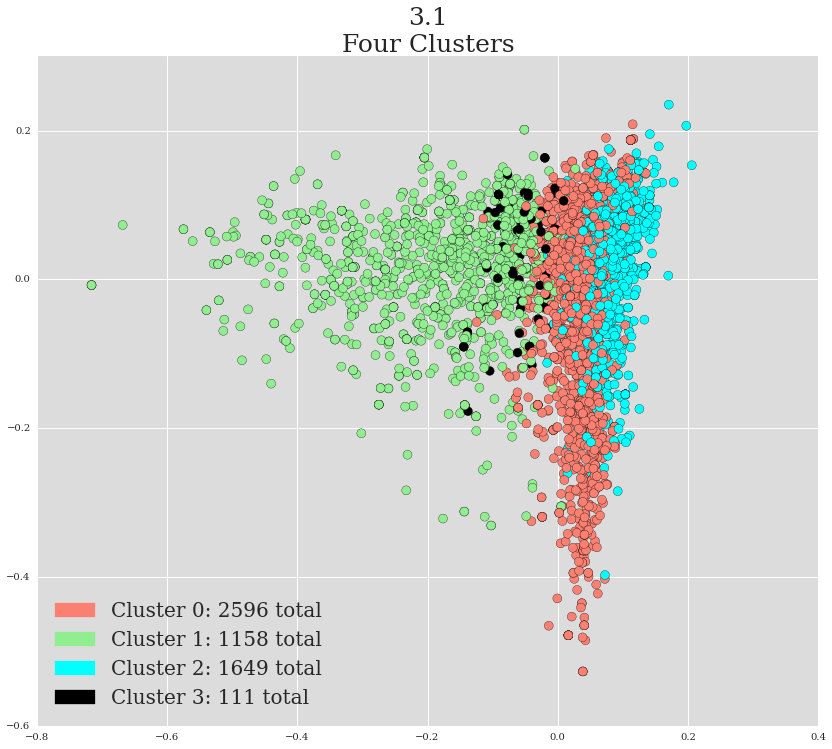

In [16]:
# generate a plot based on 2d data and color by DBSCAN labels to see the clustering
# plot setup
fig = plt.figure(figsize=(14,12))
cmap_list = ['salmon', 'lightgreen', 'aqua', 'k']
cmap = ListedColormap(cmap_list)
ax = fig.add_subplot(111)
ax.set_axis_bgcolor('gainsboro')
ax.set_title('3.1\nFour Clusters', fontsize=25, family='serif')
ax.scatter(pca_decomp['x'].values,
           pca_decomp['y'].values,
           c = pca_decomp['dbscan_labels'],
           cmap = cmap,
           s=80,
           )
# Patches for legend
klab_totals = Counter(short_jobDataFrame.klab)
patch_0 = mpatches.Patch(color=cmap.colors[0],
                         label='Cluster 0: {} total'.format(klab_totals[0]))
patch_1 = mpatches.Patch(color=cmap.colors[1],
                         label='Cluster 1: {} total'.format(klab_totals[1]))
patch_2 = mpatches.Patch(color=cmap.colors[2],
                         label='Cluster 2: {} total'.format(klab_totals[2]))
patch_3 = mpatches.Patch(color=cmap.colors[3],
                         label='Cluster 3: {} total'.format(klab_totals[3]))
ax.legend(handles=[patch_0, patch_1, patch_2, patch_3], fontsize=20, loc=3)

### 3.2 Review Several Samples

In [17]:
# output job descriptions by group / cluster
for i in range(4):
    print('\x1b[1;31m'+'Group ' + str(i)+'\x1b[0m')
    label_by_cluster(i, 'klab')

Group 0
'operate office machines, such as photocopiers and scanners, facsimile '
'machines, voice mail systems and personal computers....'

'assume responsibility for learning and adapting to each student’s special '
'medical, physical, communicative, and emotional needs....'

'prime or troubleshoot dialysis machine issues, involve biomed tech when '
'needed. assess patient and family learning needs formulating a patient '
'teaching plan....'

Group 1
'machine learning and unstructured data. creates user information solutions '
'for complex and large programs by developing, implementing, and maintaining '
'java...'

'data mining and machine learning algorithms – e.g. classification, '
'clustering, logistic regression. knowledge of data mining, predictive '
'analytics and machine...'

'strong knowledge of excel and/or data mining tools such as access, sql, or '
'sas. summary of responsibilities:....'

Group 2
'experience working with fax machines, computer software, and telephone '
'tec

In [18]:
# verify job clustering
# note that the smallest cluster is really a blend of medical jargon with some technology terms

# generate job summaries by cluster label generated by DBSCAN
for n in range(4):
    top20_by_cluster(n, 'klab')


Group (Cluster) of primary interest: 1

---------------------------------------
--- Group number: 0
---------------------------------------
--- Top Words by Occurrence
---------------------------------------
'business: 818'
'python: 554'
'technologies: 535'
'experience: 526'
'research: 466'
'director: 355'
'development: 294'
'learning: 242'
---------------------------------------
--- Top Bi-Grams:
---------------------------------------
'perl & python: 100'
'years & experience: 84'
'new & technologies: 71'
'job & description: 66'
'machine & learning: 59'
'python & perl: 50'
'experience & python: 45'
'python & ruby: 44'
'business & process: 43'
'java & python: 42'
---------------------------------------
--- Top Sentences:
---------------------------------------
'extensive programming experience in python.: 18'
'computers, fax and copier machines.: 10'
'providing industry best ci/cd to openstack/python projects.: 7'


---------------------------------------
--- Group number: 1
---------

### 3.3 I'm really only interested in two Catagories, jobs I want and jobs I do not want. 

In [19]:
# relabel jobs into two categories
binary_labs = []
for lab in short_jobDataFrame['klab'].values:
    if lab == maxCluster4[0]:
        binary_labs.append(1)
    else:
        binary_labs.append(0)
short_jobDataFrame['binary_lab'] = Series(np.asarray(binary_labs), index=short_jobDataFrame.index)

###### Samples From Each of the Above Clusters

In [20]:
# let's look at what we have for the jobs we care about
short_jobDataFrame[['title','desc']][short_jobDataFrame.binary_lab == maxCluster4[0]].sort(ascending=False).head()

,title,desc
2015-05-28 15:07:11,"vp, ops perf & analytics","proficient understanding of data mining, stati..."
2015-05-28 09:03:24,sr business strategy analyst,strong understanding of data sources/warehouse...
2015-05-28 09:03:06,business strategy analyst i," understanding of data sources/warehouses, da..."
2015-05-28 06:28:48,"senior manager, analytics and reporting","lead the team responsible for designing, devel..."
2015-05-28 01:55:08,senior financial analyst,"complete market research, data mining, busines..."


In [21]:
# let's look at what we have for the jobs we DO NOT care about
short_jobDataFrame[['title','desc']][short_jobDataFrame.binary_lab != maxCluster4[0]].sort(ascending=False).head()

,title,desc
2015-05-28 16:31:46,assoc dir user experience research,acts as main contact with other organizations ...
2015-05-28 16:05:24,technology specialist,"technology specialist - richardson, tx. best e..."
2015-05-28 15:53:42,director of delivery,5 years of experience successfully managing cr...
2015-05-28 14:15:47,receptionist/project administrative assistant,technical editing and formatting of project re...
2015-05-28 13:27:37,sr. associate corporate advance analyst,identify opportunities and potential financial...


### 4.0 Evalute Several Models

In [22]:
# derived class needed to allow Gaussian NB with sparce data
class ToDensePipe(object):
    def fit(self, X, y=None):
        pass
    def fit_transform(self, X, y=None):
        return self.transform(X)
    def transform(self, X, y=None):
        return X.toarray()

# use newly created binary labels
X_train, X_test, y_train, y_test = cross_validation.train_test_split(short_jobDataFrame.desc,
                                                    short_jobDataFrame.binary_lab,
                                                    test_size=0.2,
                                                    random_state=42)

# GaussianNB
pipe_gauss = pipeline.Pipeline([('vect', feature_extraction.text.CountVectorizer()),
                          ('tfidf', feature_extraction.text.TfidfTransformer()),
                          ('densify', ToDensePipe()), # see above
                          ("gauss", naive_bayes.GaussianNB())
                         ])
pipe_gauss.fit(X_train, y_train)
gaussian_Naive_Bayes = metrics.accuracy_score(pipe_gauss.predict(X_test), y_test)

# MultinomialNB
pipe_multi = pipeline.Pipeline([('vect', feature_extraction.text.CountVectorizer()),
                          ('tfidf', feature_extraction.text.TfidfTransformer()),
                          ("multi", naive_bayes.MultinomialNB())
                         ])
pipe_multi.fit(X_train, y_train)
multinomial_model = metrics.accuracy_score(pipe_multi.predict(X_test), y_test)

# BernoulliNB
pipe_bern = pipeline.Pipeline([('vect', feature_extraction.text.CountVectorizer()),
                          ('tfidf', feature_extraction.text.TfidfTransformer()),
                          ("bernoulli", naive_bayes.BernoulliNB())
                         ])
pipe_bern.fit(X_train, y_train)
multivariate_bernoulli_model = metrics.accuracy_score(pipe_bern.predict(X_test), y_test)

# Logistic Regression aka maxent
pipe_logreg = pipeline.Pipeline([('vect', feature_extraction.text.CountVectorizer()),
                          ('tfidf', feature_extraction.text.TfidfTransformer()),
                          ("logreg", LogisticRegression(multi_class='ovr'))
                         ])
pipe_logreg.fit(X_train, y_train)
logistic_regression_model = metrics.accuracy_score(pipe_logreg.predict(X_test), y_test)

print("GaussianNB = {}\nMultinomialNB = {}\nBernoulliNB = {}\nLogistic Regression = {} ".format(
    np.round(gaussian_Naive_Bayes, 2),
    np.round(multinomial_model, 2),
    np.round(multivariate_bernoulli_model, 2),
    np.round(logistic_regression_model, 2),
        )
      )

GaussianNB = 0.79
MultinomialNB = 0.91
BernoulliNB = 0.98
Logistic Regression = 0.98 


Bernoulli Naive Bayes classifier and Logistic Regression are winners; let's optimise hyperparamaters. 

### 4.1 Train, Test, Evaluate

In [23]:
# build a baseline before paramater optimization 
pipe = pipeline.Pipeline([('vect', feature_extraction.text.CountVectorizer()),
                          ('tfidf', feature_extraction.text.TfidfTransformer()),
                          ("bernoulli", naive_bayes.BernoulliNB()),
                         ])
# fit pipe
pipe.fit(X_train, y_train)

# same accruacy as above
# metrics.accuracy_score(pipe.predict(X_test), y_test)

Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...e_idf=True)), ('bernoulli', BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True))])

### 4.2 Confusion Matrix for Baseline

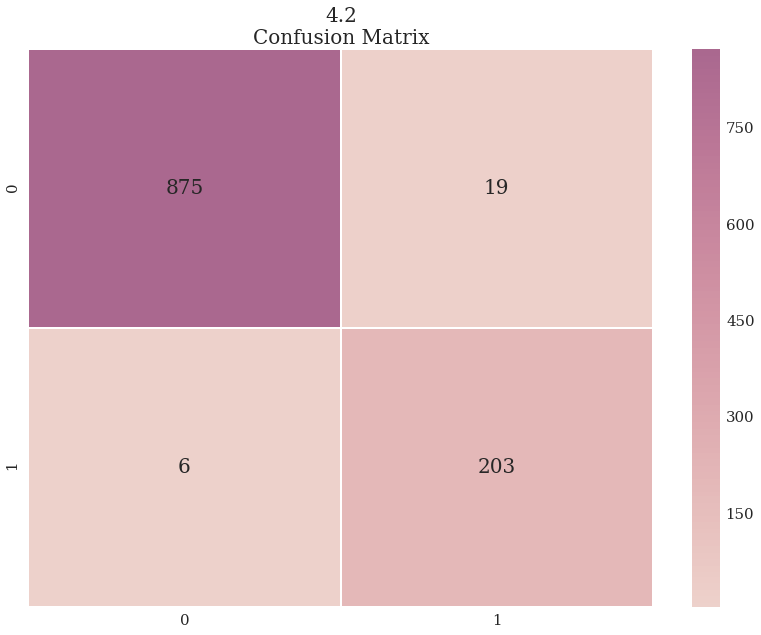

In [24]:
# Seaborn has nice looking heatmap
sns.set(font='serif')
plt.figure(figsize=(14, 10))
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.heatmap(metrics.confusion_matrix(pipe.predict(X_test), y_test),
            annot=True,
            fmt='',
            cmap=sns.cubehelix_palette(8, dark=0.5, as_cmap= True),
            annot_kws={"size": 20},
            )
plt.title('4.2\nConfusion Matrix', size=20)

In [25]:
# add new labels to dataframe
short_jobDataFrame['nb_lab'] = pipe.predict(short_jobDataFrame.desc)

In [26]:
# hyperparamaters for grid search pipe
params = dict(vect__max_df=[0.5, 1.0],
              vect__max_features = range(2,26),
              vect__ngram_range = [(1, 1), (1, 2)],
              vect__stop_words = ['english', None],
              tfidf__use_idf = [True, False],
              tfidf__norm = ['l1', 'l2'],
              bernoulli__alpha = [0, .5, 1],
              bernoulli__binarize = np.arange(0.1, 1, 0.05),
              bernoulli__fit_prior = [True, False],
             )
# number of iterations 
n_iter_search = 100
random_search = grid_search.RandomizedSearchCV(pipe,
                                               param_distributions = params,
                                               n_jobs = 4, # depends on cores
                                               n_iter = n_iter_search)

### 5.0 Run Random Search

In [27]:
# run grid search and save the best estimator in one step
best_pipe = random_search.fit(X_train, y_train).best_estimator_

metrics.accuracy_score(best_pipe.predict(X_test), y_test)

1.0

### 5.1 Confusion Matrix for Best Pipline

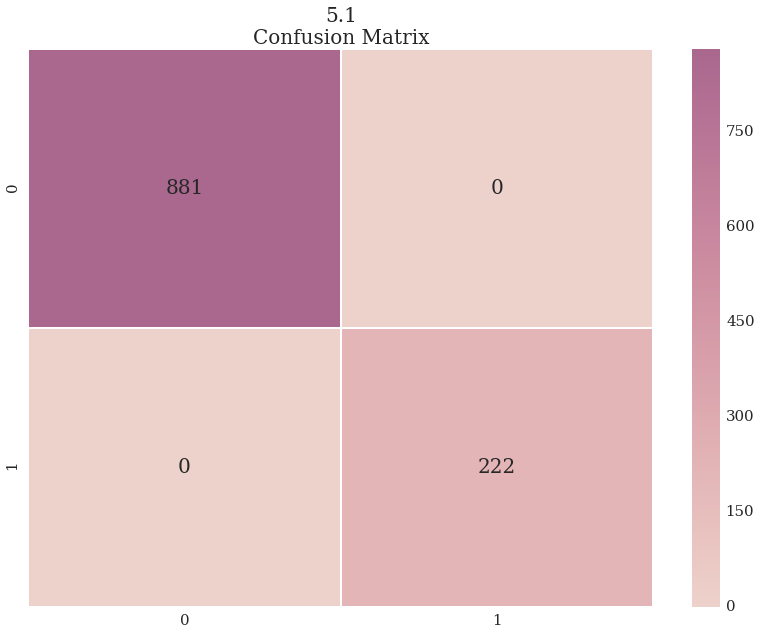

In [28]:
sns.set(font='serif')
plt.figure(figsize=(14, 10))
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.heatmap(metrics.confusion_matrix(best_pipe.predict(X_test), y_test),
            annot=True,
            fmt='',
            cmap=sns.cubehelix_palette(8, dark=0.5, as_cmap= True),
            annot_kws={"size": 20},
            )
plt.title('5.1\nConfusion Matrix', size=20)

### 5.2 Classification Report for Best Pipline

In [29]:
best_pipe = random_search.best_estimator_
# same infomation as above
# print(metrics.classification_report(best_pipe.predict(X_test), y_test))

In [30]:
# add new prediction column based on the best pipline
short_jobDataFrame['bestklab'] = best_pipe.predict(short_jobDataFrame.desc)
# use decomp with new labels
pca_decomp['best_nb_labels'] = Series(short_jobDataFrame.bestklab.values)

###### We can see two clusters in plot 5.2, The smallest cluster is poorly defined and has been tagged as the uninteresting group.

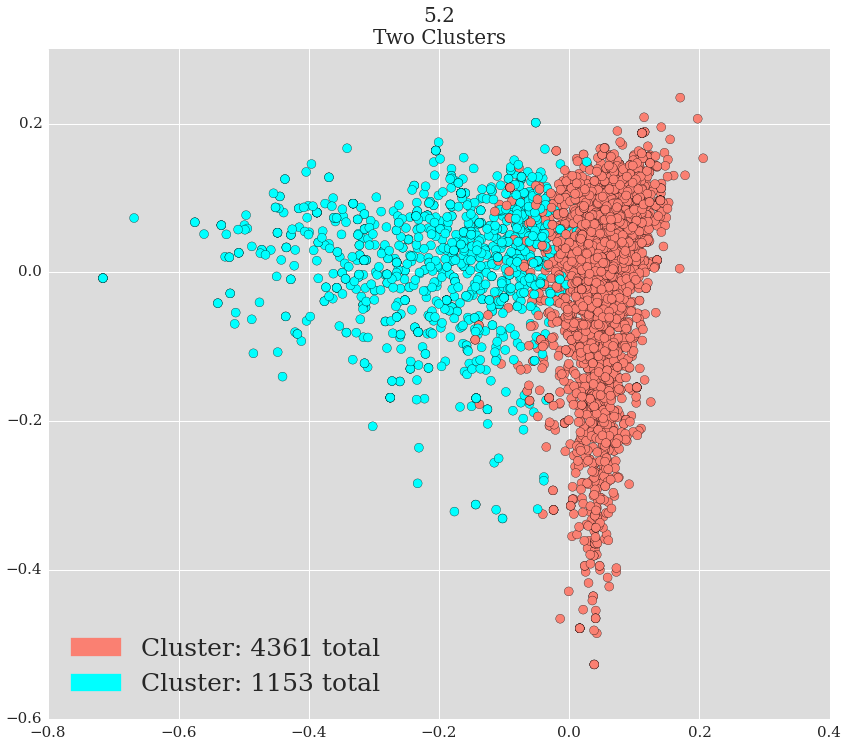

In [32]:
# note that we are using the same PCA data and just coloring ponint by the new labels
fig = plt.figure(figsize=(14,12))
cmap_list = ['salmon', 'aqua']
cmap = ListedColormap(cmap_list)
ax = fig.add_subplot(111)
ax.set_axis_bgcolor('gainsboro')
ax.set_title('5.2\nTwo Clusters', fontsize=20)
ax.scatter(pca_decomp['x'].values,
           pca_decomp['y'].values,
           c = pca_decomp['best_nb_labels'],
           cmap = cmap,
           s=80,
           )
bestklab_totals = Counter(short_jobDataFrame.bestklab)
patch_0 = mpatches.Patch(color=cmap.colors[0],
                         label='Cluster: {} total'.format(bestklab_totals[0]))
patch_1 = mpatches.Patch(color=cmap.colors[1],
                         label='Cluster: {} total'.format(bestklab_totals[1]))
ax.legend(handles=[patch_0, patch_1], fontsize=25, loc=3)

In [33]:
# generate job summaries by cluster
for n in range(2):
    top20_by_cluster(n, 'bestklab')


Group (Cluster) of primary interest: 1

---------------------------------------
--- Group number: 0
---------------------------------------
--- Top Words by Occurrence
---------------------------------------
'technology: 2252'
'business: 1111'
'experience: 805'
'research: 747'
'technologies: 742'
'director: 627'
'python: 578'
'information: 533'
---------------------------------------
--- Top Bi-Grams:
---------------------------------------
'information & technology: 367'
'years & experience: 143'
'perl & python: 104'
'new & technologies: 96'
'technology & solutions: 76'
'job & description: 70'
'machine & learning: 67'
'bachelor’s & degree: 62'
'python & perl: 55'
'research & development: 54'
---------------------------------------
--- Top Sentences:
---------------------------------------
'extensive programming experience in python.: 18'
'what happens when you combine technology with travel?...: 17'
'these technologies include cloud computing, software (saa.: 17'
'completion of two (

In [34]:
# Group 1 is definiatly what I'm interested in
for i in range(4):
    print('\x1b[1;31m'+'Group ' + str(i)+'\x1b[0m')
    label_by_cluster(i, 'bestklab', 10)

Group 0
'operate office machines, such as photocopiers and scanners, facsimile '
'machines, voice mail systems and personal computers....'

'assume responsibility for learning and adapting to each student’s special '
'medical, physical, communicative, and emotional needs....'

'prime or troubleshoot dialysis machine issues, involve biomed tech when '
'needed. assess patient and family learning needs formulating a patient '
'teaching plan....'

'qualifications eight years edi ec b2b experience as an edi business analyst '
'excellent knowledge of ai mapping requirements experience with x12, '
'edifact,...'

'capital one, a fortune 500 company and one of the nation’s top 10 banks, '
'offers a broad spectrum of financial products and services to consumers, '
'small'

'are you a passionate leader with a pulse on innovative technologies and '
'solutions? a seasoned it project manager, with full software lifecycle '
'expertise? at'

'computer, printer, copier, fax machine, multi-line telephon

### Future Directions:

We are overfiting the data but it's acceptable in this case. In practice I've manually adjusted a dataset that was initially clustered by DBSCAN. This manual adjustment is time consuming and doesn't really add much.

Add logistic regression pipe for comparison to Bernoulli pipeline.

In [37]:
# Let's take a look at how the labels compare. I'm using the sklearn confusion matrix to 
# show where the labels differ
from itertools import combinations
for p in combinations(list(short_jobDataFrame.columns.values[6:9]), 2):
    pp.pprint(p[0] + ' / ' + p[1])
    print(metrics.confusion_matrix(short_jobDataFrame[p[0]], short_jobDataFrame[p[1]]))
    print()

'binary_lab / nb_lab'
[[4329   27]
 [  60 1098]]

'binary_lab / bestklab'
[[4356    0]
 [   5 1153]]

'nb_lab / bestklab'
[[4334   55]
 [  27 1098]]

